# 부동산 허위매물 분류 해커톤

## Data Import


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

plt.style.use('bmh')
plt.rcParams['font.family'] = 'Malgun Gothic'

In [2]:
train = pd.read_csv('https://raw.githubusercontent.com/han942/vscode/refs/heads/main/datafile/dacon/fakerealestate/train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/han942/vscode/refs/heads/main/datafile/dacon/fakerealestate/test.csv')
submit = pd.read_csv('https://raw.githubusercontent.com/han942/vscode/refs/heads/main/datafile/dacon/fakerealestate/sample_submission.csv')

In [3]:
train.head()

,ID,매물확인방식,보증금,월세,전용면적,해당층,총층,방향,방수,욕실수,주차가능여부,총주차대수,관리비,중개사무소,제공플랫폼,게재일,허위매물여부
0,TRAIN_0000,현장확인,402500000.0,470000,NaN,NaN,15.0,서향,1.0,1.0,가능,40.0,96,t93Nt6I2I0,B플랫폼,2024-10-09,0
1,TRAIN_0001,현장확인,170500000.0,200000,NaN,3.0,4.0,남동향,2.0,1.0,불가능,NaN,0,q39iV5J4E6,D플랫폼,2024-12-26,0
2,TRAIN_0002,전화확인,114000000.0,380000,NaN,2.0,3.0,동향,1.0,1.0,불가능,NaN,0,b03oE4G3F6,A플랫폼,2024-11-28,0
3,TRAIN_0003,현장확인,163500000.0,30000,36.3,3.0,9.0,남동향,2.0,1.0,가능,13.0,10,G52Iz8V2B9,A플랫폼,2024-11-26,0
4,TRAIN_0004,현장확인,346000000.0,530000,NaN,3.0,3.0,동향,2.0,1.0,불가능,NaN,0,N45gM0M7R0,B플랫폼,2024-06-25,1


In [4]:
test.head()

,ID,매물확인방식,보증금,월세,전용면적,해당층,총층,방향,방수,욕실수,주차가능여부,총주차대수,관리비,중개사무소,제공플랫폼,게재일
0,TEST_000,서류확인,223000000.0,530000,NaN,5.0,5.0,남향,1.0,1.0,불가능,NaN,7,Z86Th6S3K5,D플랫폼,2024-10-21
1,TEST_001,서류확인,150500000.0,590000,30.26,7.0,11.0,서향,1.0,1.0,불가능,16.0,11,G52Iz8V2B9,D플랫폼,2023-09-02
2,TEST_002,현장확인,47000000.0,200000,41.50,2.0,3.0,남서향,2.0,1.0,불가능,NaN,0,N45gM0M7R0,B플랫폼,2024-04-03
3,TEST_003,서류확인,133000000.0,250000,31.35,5.0,6.0,남향,2.0,1.0,가능,NaN,5,C41wx1K6U9,B플랫폼,2024-09-19
4,TEST_004,현장확인,108000000.0,380000,23.14,2.0,3.0,남향,1.0,1.0,불가능,NaN,0,Z68ZJ6F6L4,A플랫폼,2024-11-10


In [5]:
def summary(df):
    print(f'data shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes,columns=['data type'])
    summ['#missing'] = df.isnull().sum().values
    summ['%missing'] = df.isnull().sum().values / len(df) *100
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    
    return summ
summary(train)

data shape: (2452, 17)


,data type,#missing,%missing,#unique,min,max
ID,object,0,0.000000,2452,NaN,NaN
매물확인방식,object,0,0.000000,3,NaN,NaN
보증금,float64,0,0.000000,426,5000000.0,409000000.0
월세,int64,0,0.000000,76,0.0,750000.0
전용면적,float64,787,32.096248,800,17.5,49.97
해당층,float64,229,9.339315,21,1.0,21.0
총층,float64,16,0.652529,20,2.0,21.0
방향,object,0,0.000000,8,NaN,NaN
방수,float64,16,0.652529,2,1.0,2.0
욕실수,float64,18,0.734095,2,1.0,2.0


In [6]:
for i in [train,test]:
    i['제공플랫폼'] = i['제공플랫폼'].apply(lambda x: x.replace('플랫폼',''))
    i['게재일'] = pd.to_datetime(i['게재일'],format='%Y-%m-%d')
    i['년'] = i['게재일'].dt.year
    i['월'] = i['게재일'].dt.month
    i['일'] = i['게재일'].dt.day
    i['요일'] = i['게재일'].dt.weekday
del train['게재일'],test['게재일']

## EDA

- 결측치 : 전용면적(연속형),해당층,총층,방수,욕실수,총주차대수
- 총층와 해당층 관련된 유사관계
- 관리비: 0의 의미
- 

In [7]:
df_tr = train.copy()
df_te = test.copy()

df_tr = df_tr.drop('ID',axis=1)
df_te = df_te.drop('ID',axis=1)

In [8]:
con_col = ['보증금','월세','전용면적','관리비']
cat_col = [col for col in df_tr.columns if col not in con_col]
cat_col.remove('중개사무소')

### Total Distribution

In [9]:
con_col

['보증금', '월세', '전용면적', '관리비']

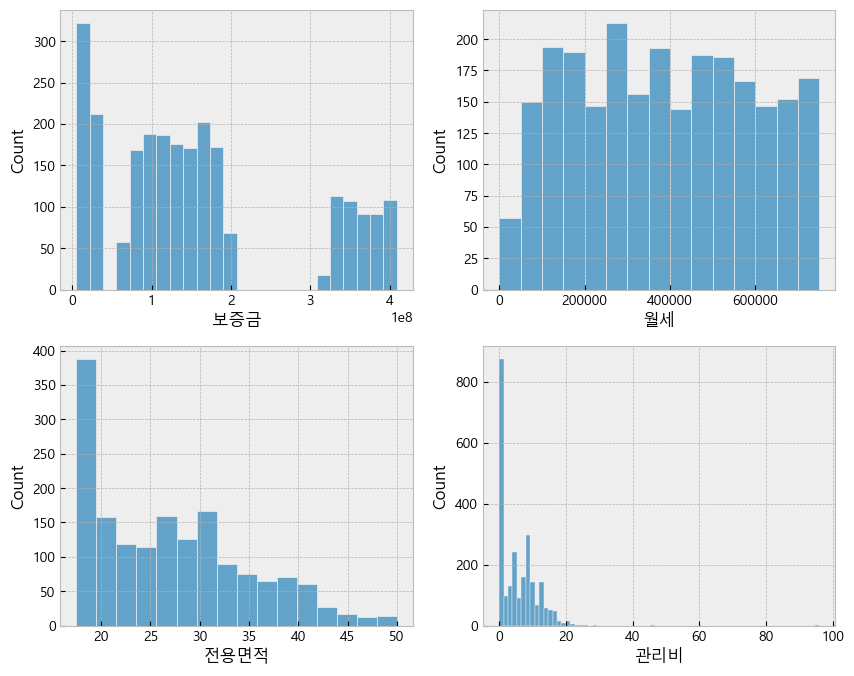

In [10]:
fig,ax = plt.subplots(2,2,figsize=(10,8))
ax = ax.flatten()

for i,col in enumerate(con_col):
    sns.histplot(df_tr[col],ax=ax[i])

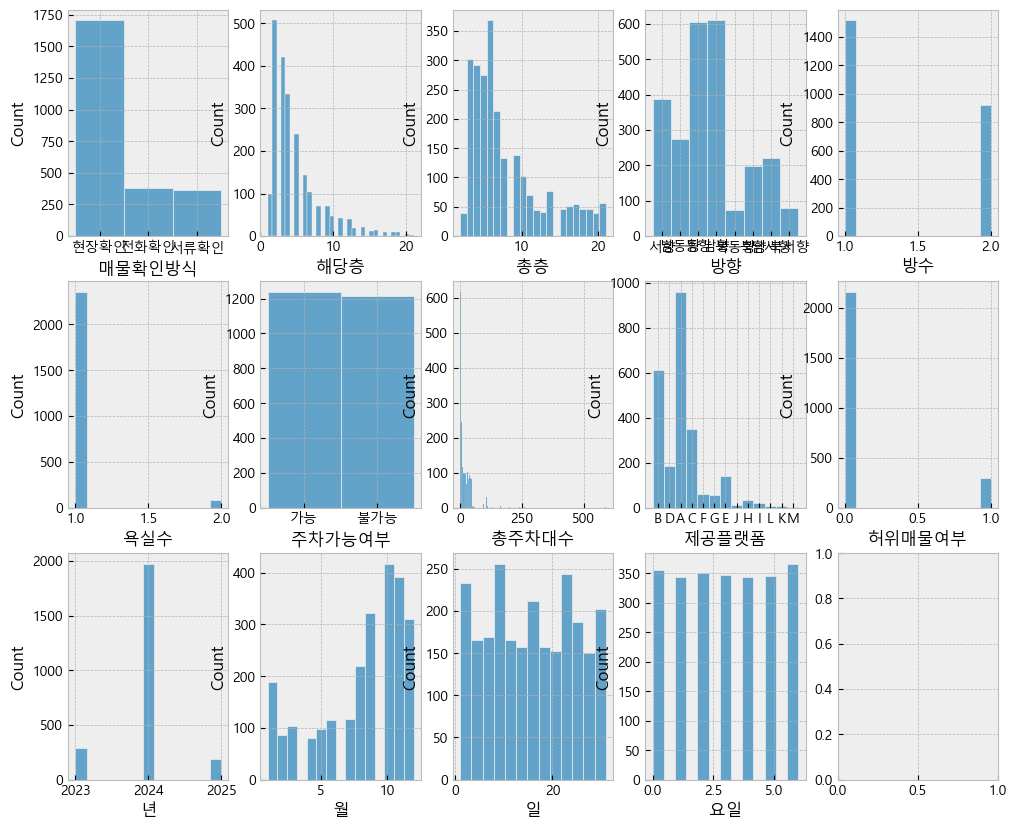

In [11]:
fig,ax = plt.subplots(3,5,figsize=(12,10))
ax = ax.flatten()

for i,col in enumerate(cat_col):
    sns.histplot(df_tr[col],ax=ax[i])

c:\Users\hanan\miniconda3\envs\jupytercode\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  func(*args, **kwargs)
c:\Users\hanan\miniconda3\envs\jupytercode\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


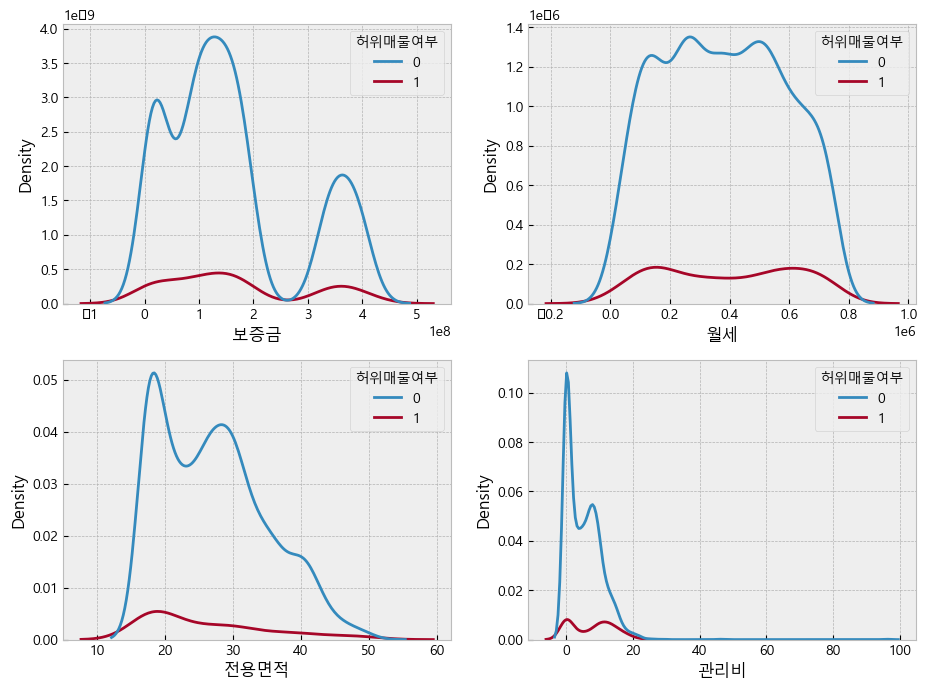

In [12]:
fig,ax = plt.subplots(2,2,figsize=(11,8))
ax = ax.flatten()

for i,col in enumerate(con_col):
    sns.kdeplot(x=df_tr[col],hue=df_tr['허위매물여부'],ax=ax[i])

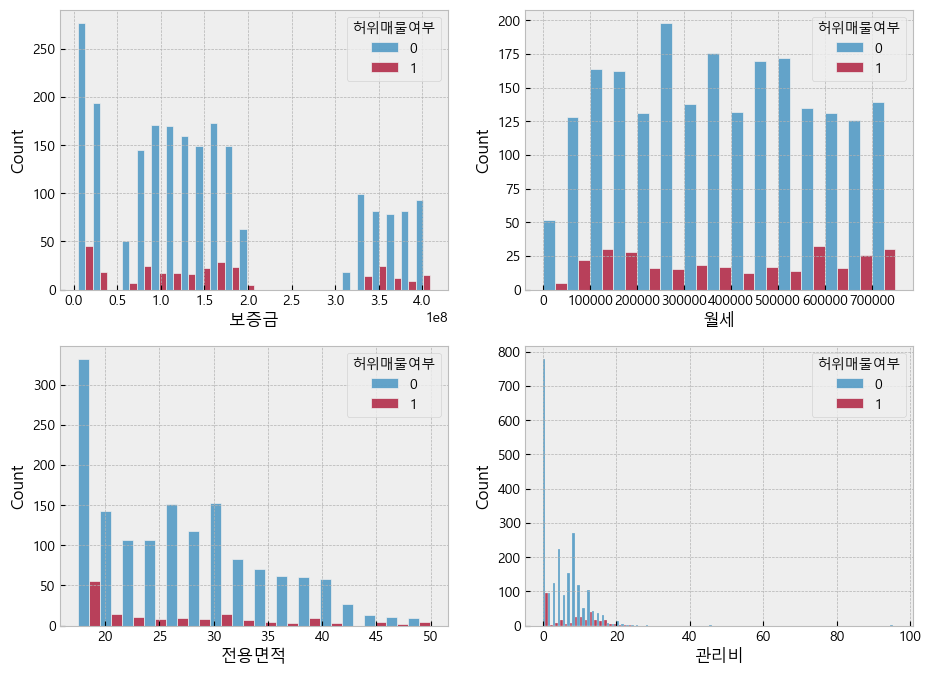

In [13]:
fig,ax = plt.subplots(2,2,figsize=(11,8))
ax = ax.flatten()

for i,col in enumerate(con_col):
    sns.histplot(x=df_tr[col],hue=df_tr['허위매물여부'],ax=ax[i],multiple='dodge')

### 1.매물 확인방식

<Axes: xlabel='매물확인방식', ylabel='Count'>

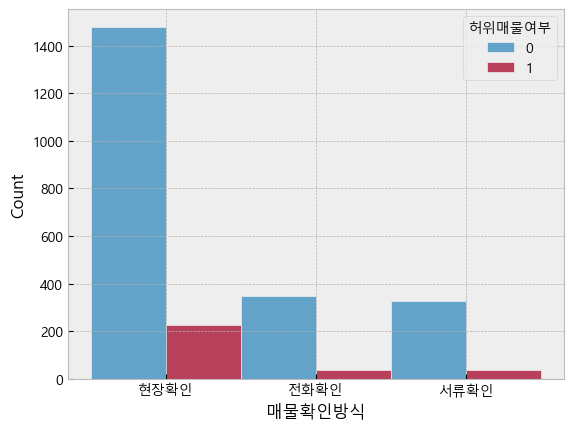

In [14]:
sns.histplot(x=df_tr['매물확인방식'],hue=df_tr['허위매물여부'],multiple='dodge')

### 2. 보증금 & 월세
- 허위매물 보증금/월세 분포도 전체 보증금/월세를를 따라감 => 별다른 전처리X
- 월세와 보증금 간의 관계: 일정부분의 상관관계?

<Axes: xlabel='보증금', ylabel='Count'>

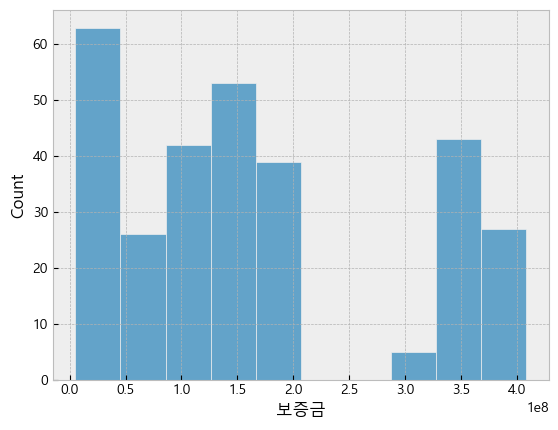

In [15]:
sns.histplot(x=df_tr['보증금'].loc[df_tr['허위매물여부']==1])

<Axes: xlabel='월세', ylabel='보증금'>

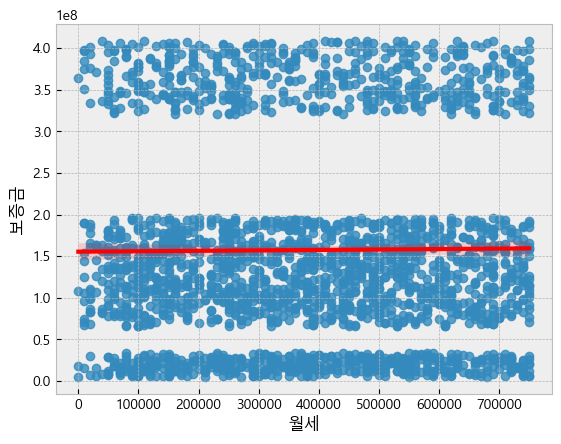

In [16]:
sns.regplot(x=df_tr['월세'],y=df_tr['보증금'],line_kws={'color':'red'})

### 3.전용면적
- 결측치가 존재 1/6정도(787개)
- 전용면적은 방의 갯수,월세,보증금 등 여럿 변수에 영향을 받는다.
- 최소면적인 17.5의 방이 300개
    - 당연하게도? 17.5인 방에 허위매물이 많음(**12%**)
    
- 월세 / 보증금과 그렇게 특이한 부분이 띄진 않음.
- 결측치 / 결측치가 아닌 data의 target 비율이 비슷함.


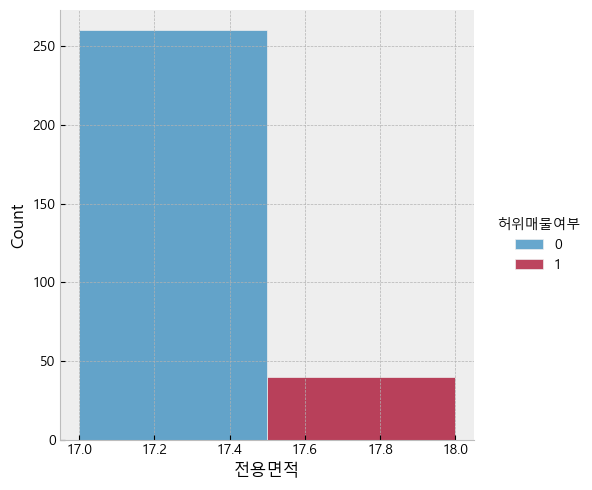

In [17]:
sns.displot(x=df_tr['전용면적'].loc[df_tr['전용면적']==17.5],hue=df_tr['허위매물여부'],multiple='dodge')

Text(0.5, 1.0, '허위매물의 전용면적 분포')

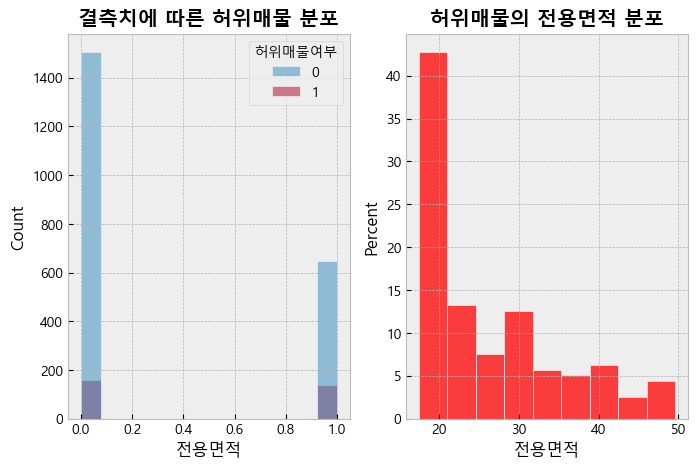

In [18]:
fig,ax = plt.subplots(1,2,figsize=(8,5))
sns.histplot(x=df_tr['전용면적'].isna(),hue=df_tr['허위매물여부'],ax=ax[0])
sns.histplot(df_tr['전용면적'].loc[df_tr['허위매물여부']==1], color='red', stat='percent',ax=ax[1])
ax[0].set_title('결측치에 따른 허위매물 분포',weight='bold')
ax[1].set_title('허위매물의 전용면적 분포',weight='bold')

<Axes: xlabel='전용면적', ylabel='월세'>

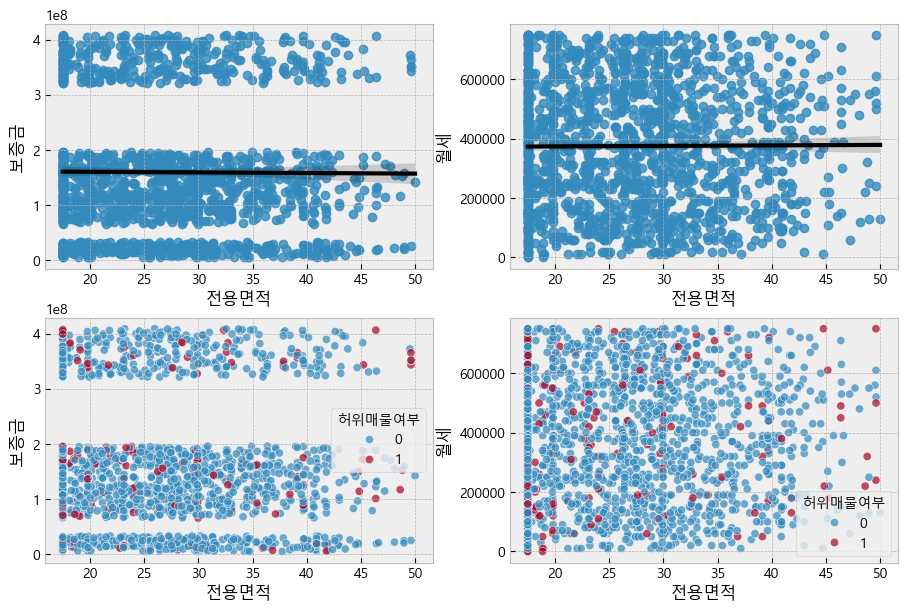

In [19]:
fig,ax = plt.subplots(2,2,figsize=(11,7))
ax=ax.flatten()
sns.regplot(x='전용면적',y='보증금',data=df_tr,line_kws={'color':'black'},ax=ax[0])
sns.regplot(x='전용면적',y='월세',data=df_tr,line_kws={'color':'black'},ax=ax[1])
sns.scatterplot(x='전용면적',y='보증금',data=df_tr,hue='허위매물여부',ax=ax[2],alpha=0.7)
sns.scatterplot(x='전용면적',y='월세',data=df_tr,hue='허위매물여부',ax=ax[3],alpha=0.7)

### 4. 해당층 / 총층
- 해당층 // 총층의 값을 '층비율' 변수 정의로 하면 좋을듯.

- 총층이 결측치면 무조건 해당층도 결측치임. (총층:16개 / 해당층:229)
    - 총층 결측치는 삭제해도 괜찮을듯
    - 결측치 내부의 허위매물 비율도 별 특징 없는듯


Text(0.5, 1.0, '총층 분포')

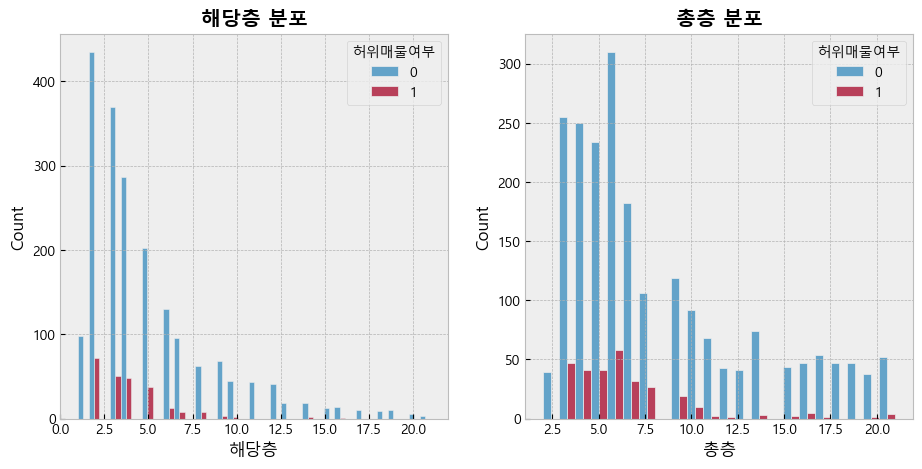

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))
sns.histplot(x=df_tr['해당층'], hue=df_tr['허위매물여부'], multiple='dodge', ax=ax[0])
ax[0].set_title('해당층 분포',weight='bold')

sns.histplot(x=df_tr['총층'], hue=df_tr['허위매물여부'], multiple='dodge', ax=ax[1])
ax[1].set_title('총층 분포',weight='bold')

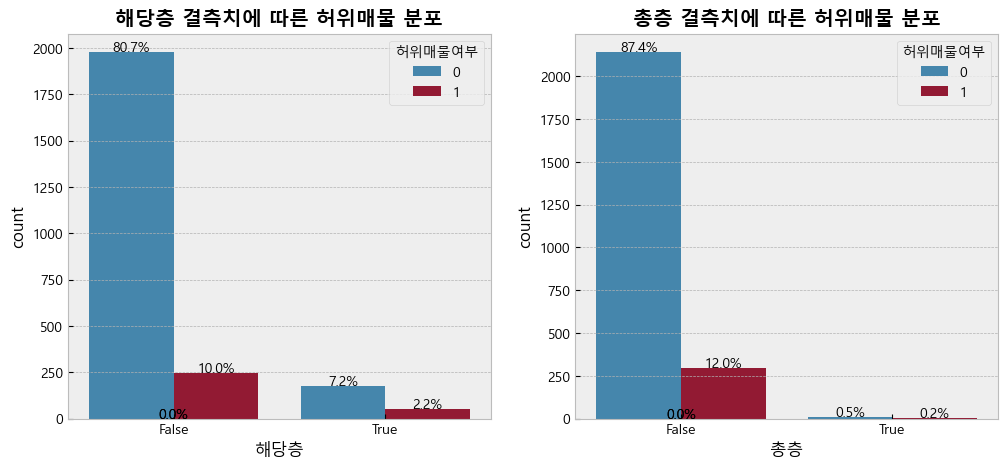

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.countplot(x=df_tr['해당층'].isna(), hue=df_tr['허위매물여부'], ax=ax[0])
ax[0].set_title('해당층 결측치에 따른 허위매물 분포', weight='bold')

sns.countplot(x=df_tr['총층'].isna(), hue=df_tr['허위매물여부'], ax=ax[1])
ax[1].set_title('총층 결측치에 따른 허위매물 분포', weight='bold')
# Adding percentage labels on the bars
for a in ax:
    for p in a.patches:
        height = p.get_height()
        total = len(df_tr)
        a.text(p.get_x() + p.get_width() / 2., height + 3,
               f'{height/total:.1%}', ha="center")

### 5. 방향

<Axes: xlabel='방향', ylabel='Density'>

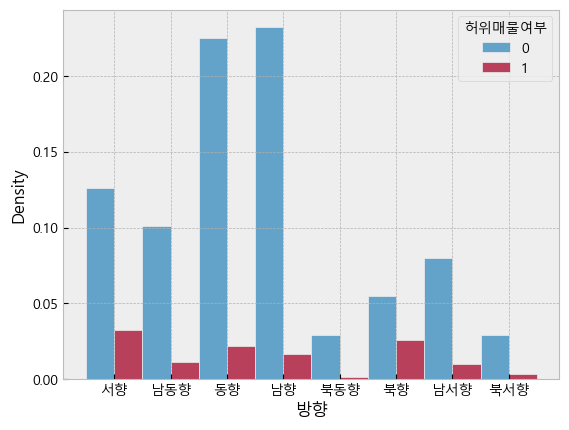

In [22]:
sns.histplot(x=df_tr['방향'],hue=df_tr['허위매물여부'],multiple='dodge',stat='density')

### 6. 방수 / 욕실수
- 결측치가 별로 없음. (방수:16 / 욕실:18)
    - 방수,총층의 결측치(16개)가 모두 겹침(이부분은 제거하는게 맞을듯)
    - 결측치의 합집합은 1171 칼럼.
- 방 수에 따라서 허위매물에 영향을 끼치는게 있을듯. (특히 2개)

In [23]:
df_tr[['전용면적','해당층','총층','방수','욕실수','총주차대수']][df_tr.isna().any(axis=1)]

,전용면적,해당층,총층,방수,욕실수,총주차대수
0,NaN,NaN,15.0,1.0,1.0,40.0
1,NaN,3.0,4.0,2.0,1.0,NaN
2,NaN,2.0,3.0,1.0,1.0,NaN
4,NaN,3.0,3.0,2.0,1.0,NaN
5,29.50,NaN,3.0,2.0,1.0,1.0
...,...,...,...,...,...,...
2445,NaN,2.0,5.0,1.0,1.0,NaN
2446,17.50,NaN,14.0,1.0,1.0,104.0
2447,48.95,3.0,3.0,2.0,1.0,NaN
2448,NaN,2.0,4.0,1.0,1.0,NaN


In [24]:
df_tr.loc[df_tr['방수'].isna() & df_tr['총층'].isna()][['전용면적','해당층','총층','방수','욕실수','총주차대수']]

,전용면적,해당층,총층,방수,욕실수,총주차대수
37,NaN,NaN,NaN,NaN,NaN,NaN
76,NaN,NaN,NaN,NaN,NaN,NaN
88,NaN,NaN,NaN,NaN,NaN,NaN
153,NaN,NaN,NaN,NaN,NaN,1.0
339,NaN,NaN,NaN,NaN,NaN,NaN
456,NaN,NaN,NaN,NaN,NaN,4.0
515,NaN,NaN,NaN,NaN,NaN,NaN
546,NaN,NaN,NaN,NaN,NaN,NaN
686,NaN,NaN,NaN,NaN,NaN,NaN
952,NaN,NaN,NaN,NaN,NaN,NaN


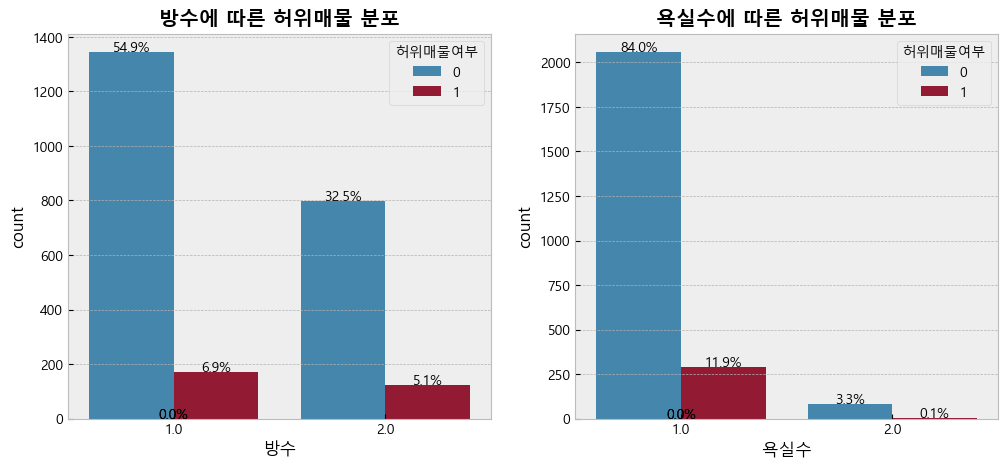

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.countplot(x=df_tr['방수'], hue=df_tr['허위매물여부'], ax=ax[0])
ax[0].set_title('방수에 따른 허위매물 분포', weight='bold')

sns.countplot(x=df_tr['욕실수'], hue=df_tr['허위매물여부'], ax=ax[1])
ax[1].set_title('욕실수에 따른 허위매물 분포', weight='bold')

# Adding percentage labels on the bars
for p in ax[0].patches:
    height = p.get_height()
    total = len(df_tr)
    ax[0].text(p.get_x() + p.get_width() / 2., height + 3,
               f'{height/total:.1%}', ha="center")

for p in ax[1].patches:
    height = p.get_height()
    total = len(df_tr)
    ax[1].text(p.get_x() + p.get_width() / 2., height + 3,
               f'{height/total:.1%}', ha="center")

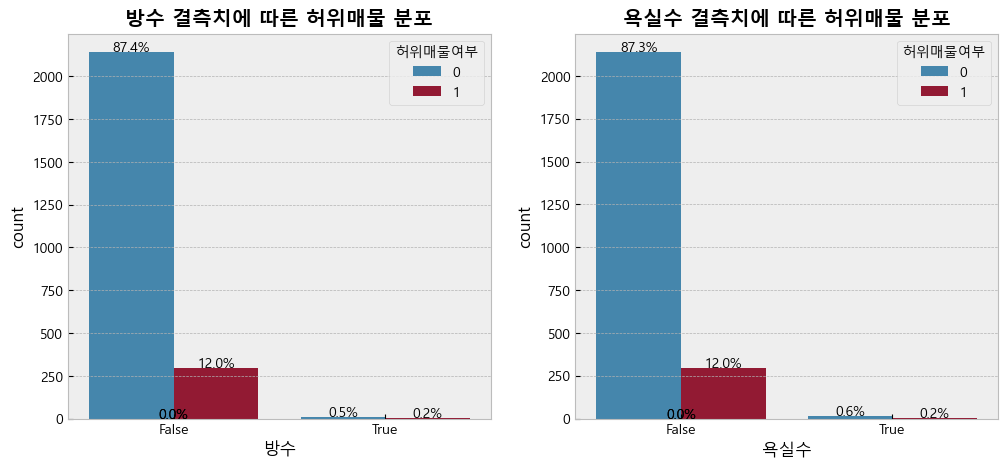

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.countplot(x=df_tr['방수'].isna(), hue=df_tr['허위매물여부'], ax=ax[0])
ax[0].set_title('방수 결측치에 따른 허위매물 분포', weight='bold')

sns.countplot(x=df_tr['욕실수'].isna(), hue=df_tr['허위매물여부'], ax=ax[1])
ax[1].set_title('욕실수 결측치에 따른 허위매물 분포', weight='bold')
# Adding percentage labels on the bars
for a in ax:
    for p in a.patches:
        height = p.get_height()
        total = len(df_tr)
        a.text(p.get_x() + p.get_width() / 2., height + 3,
               f'{height/total:.1%}', ha="center")

### 7.주차가능여부 / 총주차대수
- 총주차대수의 결측치에 꽤 많은 허위매물이 존재함.
- 100~300대의 주차공간이 가능한 매물 / 600개 이상의 주차공간을 가진 곳도 존재
    - 이상치로 치부할것인가?

- 주차가능여부가 불가능인데 총주차대수가 기록되어있는 데이터??
    - 총주차대수 결측치(696개) 중 주차불가능:585개

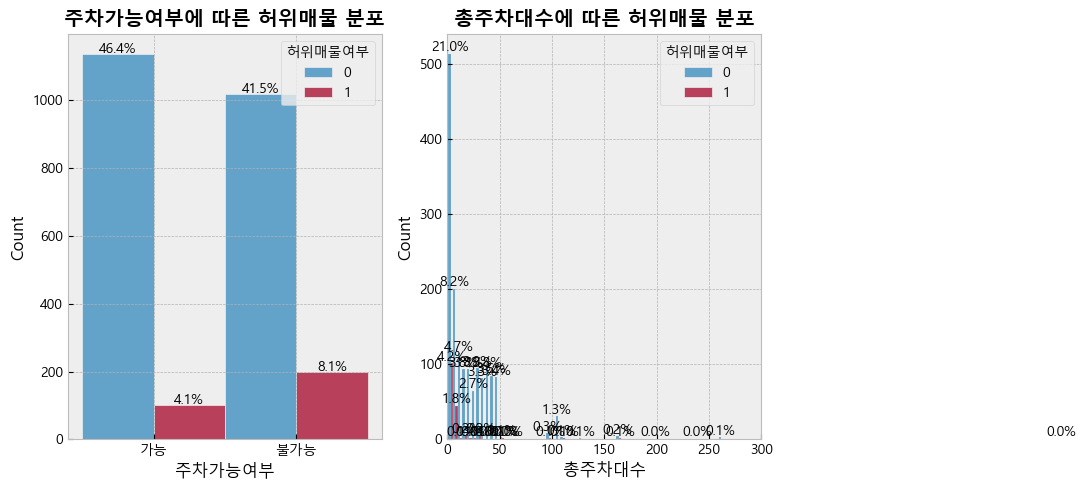

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(x=df_tr['주차가능여부'], hue=df_tr['허위매물여부'], multiple='dodge', ax=ax[0])
ax[0].set_title('주차가능여부에 따른 허위매물 분포', weight='bold')

sns.histplot(x=df_tr['총주차대수'], hue=df_tr['허위매물여부'], ax=ax[1],multiple='dodge')
ax[1].set_title('총주차대수에 따른 허위매물 분포', weight='bold')
ax[1].set_xlim(0,300)
# Adding percentage labels on the bars
for a in ax:
    for p in a.patches:
        height = p.get_height()
        total = len(df_tr)
        if height / total > 0.0:
            a.text(p.get_x() + p.get_width() / 2., height + 3,
               f'{height/total:.1%}', ha="center")
plt.tight_layout()

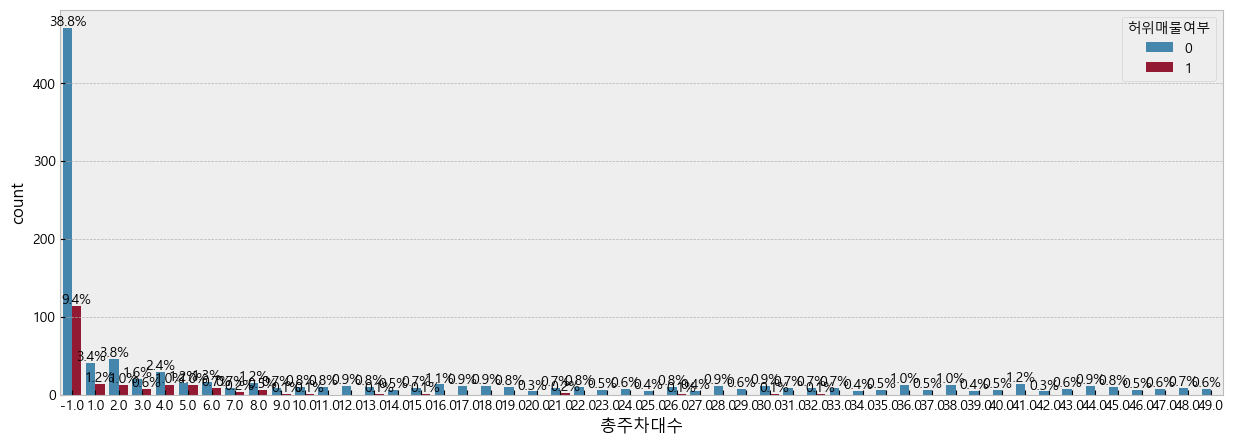

In [28]:
df_miss = df_tr.loc[(df_tr['주차가능여부']=='불가능')][['허위매물여부','총주차대수']]
df_miss.fillna(-1, inplace=True)
fig, ax = plt.subplots(figsize=(15, 5))
sns.countplot(x=df_miss['총주차대수'].loc[df_miss['총주차대수']<50], hue=df_miss['허위매물여부'], ax=ax)
# Adding percentage labels on the bars
total = len(df_miss)
for p in ax.patches:
    height = p.get_height()
    if height / total > 0.0:
        ax.text(p.get_x() + p.get_width() / 2., height + 3,
                f'{height/total:.1%}', ha="center")

<Axes: ylabel='총주차대수'>

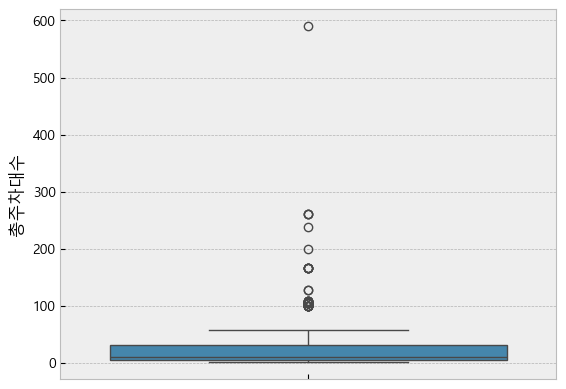

In [29]:
sns.boxplot(df_tr['총주차대수'])

Text(0.5, 1.0, '허위매물의 총주차대수 분포')

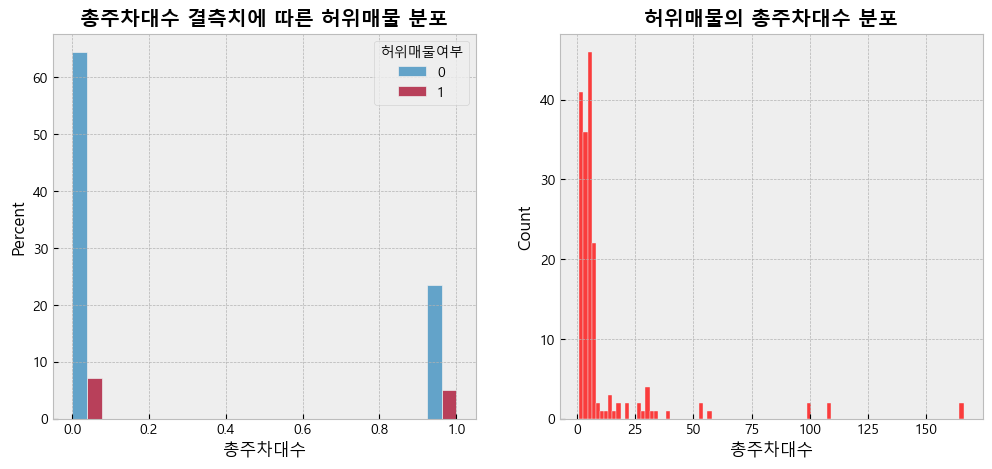

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(x=df_tr['총주차대수'].isna(), hue=df_tr['허위매물여부'], multiple='dodge', stat='percent', ax=ax[0])
ax[0].set_title('총주차대수 결측치에 따른 허위매물 분포', weight='bold')
sns.histplot(x=df_tr['총주차대수'].loc[df_tr['허위매물여부']==1], ax=ax[1],color='red')
ax[1].set_title('허위매물의 총주차대수 분포', weight='bold')

### 8. 관리비
- 관리비에 이상치가 몇개 존재하는듯
    - 삭제여부는 따로 보고 판단해야할듯
- 관리비가 0인 데이터가 많음 => 0의 의미?

In [40]:
print(df_tr['관리비'].loc[df_tr['허위매물여부']==1].value_counts(normalize=True)[:5])
df_tr.loc[df_tr['관리비']>20].sort_values('관리비',ascending=False)

관리비
0     0.305369
10    0.080537
13    0.067114
12    0.063758
9     0.057047
Name: proportion, dtype: float64


,매물확인방식,보증금,월세,전용면적,해당층,총층,방향,방수,욕실수,주차가능여부,총주차대수,관리비,중개사무소,제공플랫폼,허위매물여부,년,월,일,요일
0,현장확인,402500000.0,470000,NaN,NaN,15.0,서향,1.0,1.0,가능,40.0,96,t93Nt6I2I0,B,0,2024,10,9,2
518,현장확인,72500000.0,580000,NaN,3.0,5.0,남향,1.0,1.0,가능,5.0,46,Y04yg0T7Z5,B,0,2024,8,23,4
1574,현장확인,102500000.0,580000,24.01,9.0,10.0,남서향,2.0,1.0,가능,8.0,29,i23ag3Z3Y7,A,0,2024,12,13,4
2410,전화확인,14000000.0,490000,21.49,2.0,5.0,동향,1.0,1.0,가능,7.0,26,z40LO7P9C9,F,0,2024,11,27,2
1541,현장확인,33000000.0,230000,21.88,4.0,6.0,북동향,1.0,1.0,가능,8.0,25,A18IU3D9M4,B,0,2024,10,21,0
1819,전화확인,321500000.0,160000,17.50,12.0,14.0,남향,1.0,1.0,가능,104.0,23,z40LO7P9C9,F,0,2024,12,1,6
1976,현장확인,15500000.0,420000,23.14,2.0,4.0,서향,1.0,1.0,불가능,NaN,23,M02bn7Y4P0,A,1,2024,3,23,5
704,현장확인,135000000.0,720000,43.48,4.0,13.0,북향,2.0,1.0,가능,NaN,22,C41wx1K6U9,B,0,2024,9,2,0
441,전화확인,161500000.0,570000,41.65,NaN,9.0,동향,2.0,1.0,가능,50.0,22,r82ax9M3U3,B,0,2024,12,2,0
2075,현장확인,137000000.0,100000,NaN,4.0,8.0,동향,1.0,1.0,가능,3.0,22,Q39nx9D3P1,D,0,2024,9,11,2


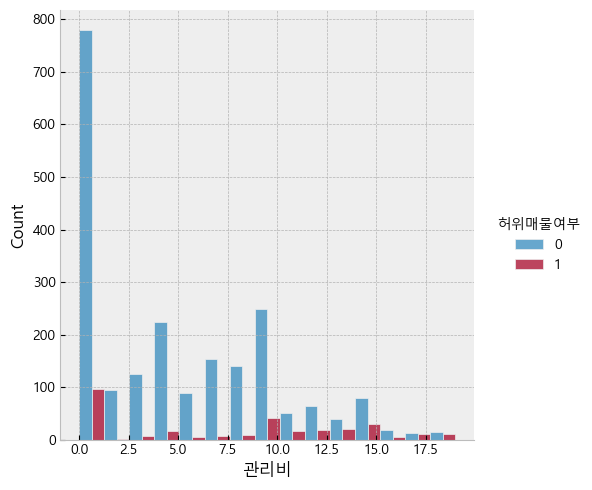

In [ ]:
#0인 허위매물의 비율이 30%
sns.displot(x=df_tr['관리비'].loc[df_tr['관리비']<20],hue=df_tr['허위매물여부'],multiple='dodge')

### 9. 중개사무소 / 제공플랫폼
- 중개사무소에서 사기가 시작될 확률이 높다.
    - 특정 중개사무소라고 많은 허위매물이 있는건 아님.


In [50]:
df_tr.groupby('허위매물여부')['중개사무소'].value_counts()

허위매물여부  중개사무소     
0       G52Iz8V2B9    799
        r82ax9M3U3     35
        J52gJ2E4T6     24
        H90uE4C0W5     23
        b87Td0W4Y3     23
                     ... 
1       w51BQ1O6W9      1
        x64HR1L6M1      1
        x81dK5X8Z0      1
        y70Or6U6A8      1
        y83fz3N4Q6      1
Name: count, Length: 406, dtype: int64

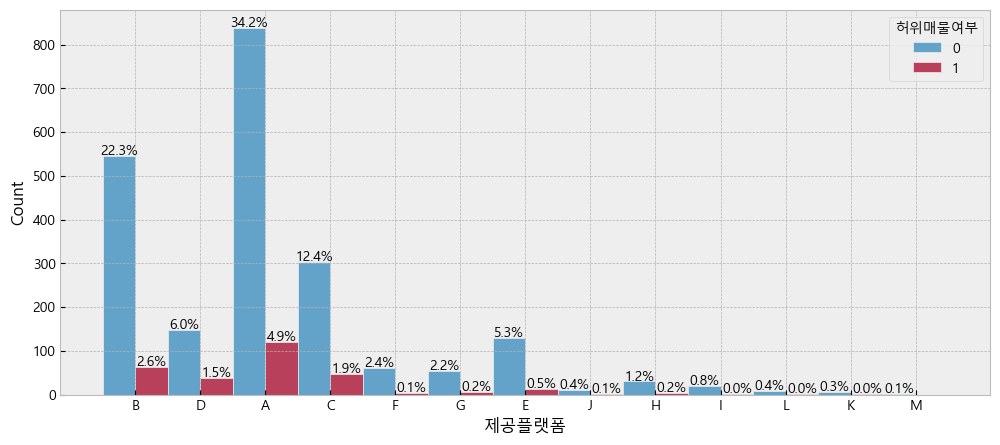

In [49]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.histplot(x=df_tr['제공플랫폼'], hue=df_tr['허위매물여부'], multiple='dodge', ax=ax)

# Adding percentage labels on the bars
total = len(df_tr)
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.text(p.get_x() + p.get_width() / 2., height + 3,
                f'{height/total:.1%}', ha="center")

## Feature Engineering

In [52]:
df_te.head()

,매물확인방식,보증금,월세,전용면적,해당층,총층,방향,방수,욕실수,주차가능여부,총주차대수,관리비,중개사무소,제공플랫폼,년,월,일,요일
0,서류확인,223000000.0,530000,NaN,5.0,5.0,남향,1.0,1.0,불가능,NaN,7,Z86Th6S3K5,D,2024,10,21,0
1,서류확인,150500000.0,590000,30.26,7.0,11.0,서향,1.0,1.0,불가능,16.0,11,G52Iz8V2B9,D,2023,9,2,5
2,현장확인,47000000.0,200000,41.50,2.0,3.0,남서향,2.0,1.0,불가능,NaN,0,N45gM0M7R0,B,2024,4,3,2
3,서류확인,133000000.0,250000,31.35,5.0,6.0,남향,2.0,1.0,가능,NaN,5,C41wx1K6U9,B,2024,9,19,3
4,현장확인,108000000.0,380000,23.14,2.0,3.0,남향,1.0,1.0,불가능,NaN,0,Z68ZJ6F6L4,A,2024,11,10,6


<Axes: >

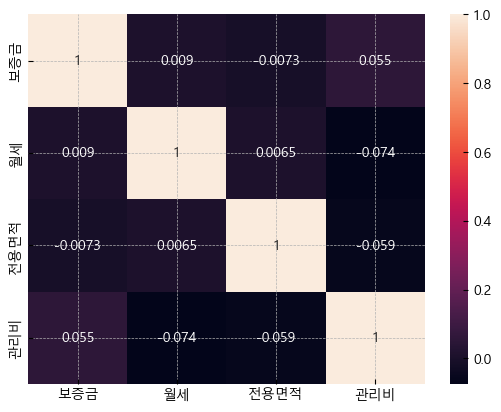

In [ ]:
sns.heatmap(df_tr[con_col].corr(),annot=True)